In [1]:
import pandas as pd
import numpy as np
import matplotlib as mp
import seaborn as sns

c:\users\lt5420\appdata\local\programs\python\python37\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


In [2]:
events = pd.read_csv('../data/events.csv.gzip', compression='gzip',\
                     parse_dates=['date'],\
                     dtype={'event_id':'category',\
                            'application_id':'category',\
                            'ref_type':'int64',\
                            'ref_hash':'int64',\
                            'attributed':'bool',\
                            'device_countrycode':'category',\
                            'device_os_version':'category',\
                            'device_brand':'category',\
                            'device_model':'category',\
                            'device_city':'category',\
                            'carrier':'category',\
                            'event_uuid':'object',\
                            'device_os':'category',\
                            'wifi':'bool',\
                            'connection_type':'category'\
                           })

c:\users\lt5420\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (12,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
events.describe(include='all').transpose()

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
date,2494423,2488829,2019-03-12 14:36:58.017000,3,2019-03-05 00:00:00.255000,2019-03-13 23:59:59.984000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
event_id,2494423,568,22,618228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ref_type,2.49442e+06,NaN,NaN,NaN,NaN,NaN,1.79416e+18,1.70794e+17,1.49452e+18,1.89152e+18,1.89152e+18,1.89152e+18,1.89152e+18
ref_hash,2.49442e+06,NaN,NaN,NaN,NaN,NaN,4.64149e+18,2.66072e+18,1.63368e+14,2.32614e+18,4.68896e+18,6.92759e+18,9.22332e+18
application_id,2494423,269,66,325696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
attributed,2494423,2,False,2489324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
device_countrycode,2494423,1,6333597102633388268,2494423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
device_os_version,1022066,81,4.3537503246500966e+18,277691,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
device_brand,1164963,250,3.083058605577787e+17,579861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
device_model,2406456,2624,2.33194661091417e+18,210697,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**device_country_code** es unico por lo que no aporta informacion para segmentar los datos.
**event_uuid** es clave unica para cada registro

In [4]:
events.shape

(2494423, 22)

In [5]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2494423 entries, 0 to 2494422
Data columns (total 22 columns):
date                  datetime64[ns]
event_id              category
ref_type              int64
ref_hash              int64
application_id        category
attributed            bool
device_countrycode    category
device_os_version     category
device_brand          category
device_model          category
device_city           category
session_user_agent    float64
trans_id              object
user_agent            float64
event_uuid            object
carrier               category
kind                  float64
device_os             category
wifi                  object
connection_type       category
ip_address            int64
device_language       float64
dtypes: bool(1), category(10), datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 247.6+ MB


In [6]:
events.sort_values(by=['ref_hash','application_id','date'], inplace=True)

In [7]:
events['next_date'] = events.groupby(['ref_hash','application_id'], as_index = False, sort=False)['date']\
                                              .transform(lambda x: x.shift(-1))

events['next_event'] = events.groupby(['ref_hash','application_id'], as_index = False, sort=False)['event_id']\
                                              .transform(lambda x: x.shift(-1))

events = events.loc[(~events['next_date'].isnull())]
events['secs_to_next'] = (events['next_date'] - events['date'])\
                                        .transform(lambda x: round(x.total_seconds(), 2))
events['hour'] = events['date'].dt.hour
events['is_weekend'] = events['date'].dt.weekday >= 5

## Tiempo entre eventos

Text(0.5,0,'Tiempo (Seg.)')

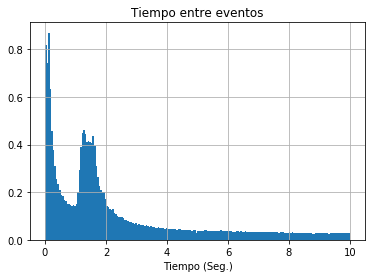

In [8]:
plt = events['secs_to_next'].loc[((events['secs_to_next'] < (10)) & (events['secs_to_next'] > 0))].hist(bins=200, density=True)
plt.set_title("Tiempo entre eventos")
plt.set_xlabel("Tiempo (Seg.)")

Se pueden ver dos picos, el primero ocurre muy cerca del 0, por lo que parece que se debe a dos eventos que ocurren en paralelo. 
Lo interesante es que practicamente todos los eventos ocurren en intervalos de no mas de 3 segundos. Tomamos 5 segundos como intervalo para no considerar que los eventos estan relacionado con el evento siguiente

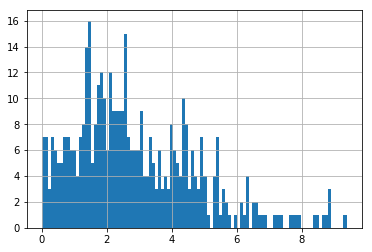

In [15]:
plt = events.loc[((events['secs_to_next'] < (10)) & (events['secs_to_next'] > 0))].groupby('event_id')['secs_to_next'].mean()